# Trust Accuracy Analysis

Inspect the decreasing-then-increasing pattern exhibited by the trust accuracy results.

In [14]:
import csv
import os
import pathlib
import json
import pickle
from pprint import pprint
import string

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline

import numpy as np
import pandas as pd

import seaborn as sns
sns.set_theme(
    context="paper",
    style="whitegrid",
#     font_scale=2,
    rc={
        'lines.linewidth': 2,
        'xtick.bottom': True,
        'ytick.left': True,
        'axes.grid': True,
        'axes.grid.axis': 'both',
        'axes.grid.which': 'both'
    }
)

In [15]:
# Use latex for exporting
# mpl.use("pgf")  # can specify this as an argument to savefig() each time
mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

## Results format

Results are stored as subfolders, each with a timestamp (e.g. `res_20220306_155424`),
in a root folder `results`.
`results` also contains a CSV called `timestamps.csv` listing the timestamps of each results folder along with configuration parameters.

Each result subfolder contains `config.json`, which gives the experimental configuration used to run experiments (must match the entry in `timestamps.csv`), and `results.json` which contains the collected data.

Each `results.json` contains a list of $N$ 2-tuples, where $N$ is the number of separate runs (each with a different random seed).
Each tuple contains the training and evaluation data respectively, each being a dictionary.
Each of these dicts are in the following key-value format: `metric : list of values over episodes` 

## Load Data

In [3]:
# Location of root folder containing all result subfolders
RESULTS_PATH = pathlib.Path("../results-debug-trustacc/")

# Names of metrics in each result folder
METRIC_NAMES = [
    'average_reward',
    'success_rate',
    'average_trust_rate',
    'mutual_trust_rate',
    'average_trust_accuracy'
]

# Convert metric names (lower case, joined by underscores) to human-readable (capitalised with spaces)
METRIC_TO_LABEL = {
    'average_reward': 'Reward',
    'average_trust_accuracy': 'Trust Accuracy',
    'average_trust_rate': 'Trust Rate',
    'mutual_trust_rate': 'Mutual Trust',
    'success_rate': 'Success Rate'
}

# Similarly, variable to human readable
VAR_TO_LABEL = {
    "noise": "$1-p$",
    "frac_reliable": "$f$"
}

RUNMODE_TO_LABEL = {
    "trained": "RLTC",
    "oracle": "Oracle",
    "trust_all" : "Trust All"
}

RUNMODES = list(RUNMODE_TO_LABEL.keys())

In [4]:
# Collect data from 
all_data = []

for path in RESULTS_PATH.iterdir():
    if not path.name.startswith("res_"):
        continue
    
    timestamp = path.name
    files = {file.name for file in path.iterdir()}
    assert files == {"config.json", "results.json"}
    
    with open(path.joinpath("config.json"), "r") as f:
        config = json.load(f)
    
    with open(path.joinpath("results.json"), "r") as f:
        results = json.load(f)
    
    row = config.copy()
    row["timestamp"] = timestamp
    row["results"] = results
    
    all_data.append(row)

In [5]:
# Basic sanity check
assert len(set(row["timestamp"] for row in all_data)) == len(all_data)
assert all(all_data[0].keys() == row.keys() for row in all_data)

COLUMN_NAMES = list(sorted(all_data[0].keys()))

df_main = pd.DataFrame(all_data)
df_main.head(3)

,num_processes,frac_reliable,noise,episode_length,run_mode,step_size,discount,epsilon,epsilon_decay_factor,num_train_episodes,num_eval_episodes,timestamp,results
0,16,0.85,0.3,30,trained,0.03,0.999,0.3,0.9996,20000,2000,res_20220325_121935551555_7,"[[{'average_reward': [-24.92307692307692, -28...."
1,16,0.85,0.2,30,trained,0.03,0.999,0.3,0.9996,20000,2000,res_20220325_112441070354_6,"[[{'average_reward': [-24.92307692307692, -28...."
2,16,0.75,0.1,30,trained,0.03,0.999,0.3,0.9996,20000,2000,res_20220320_215855576342_27,"[[{'average_reward': [-24.5, -17.8333333333333..."


In [6]:
def extract(row, metric):
    """Extract evaluation results for a particular metric."""
        
    results = row["results"]
    
    # all_train_results = []
    all_eval_results = []
    
    for train_result, eval_result in results:
        # all_train_results.append(train_result)
        all_eval_results.append(eval_result)
    
    return [item[metric] for item in all_eval_results]

# For each metric, get the raw data using extract(), then replace with averages
for metric in METRIC_NAMES:
    df_main[metric] = df_main.apply(lambda x: extract(x, metric), axis=1)
    df_main[metric] = df_main[metric].apply(lambda xs: [np.mean(x) for x in xs])

In [7]:
# Show results
# (excluding the original "results" column makes displaying faster)
df_main[df_main.columns.difference(["results"])]

,average_reward,average_trust_accuracy,average_trust_rate,discount,episode_length,epsilon,epsilon_decay_factor,frac_reliable,mutual_trust_rate,noise,num_eval_episodes,num_processes,num_train_episodes,run_mode,step_size,success_rate,timestamp
0,"[-17.457846153846155, -25.28107692307692, -22....","[13.91025641025641, 15.487179487179498, 14.217...","[11.038461538461542, 9.833333333333332, 9.5641...",0.999,30,0.3,0.9996,0.85,"[4.7222222222222205, 4.375, 5.200000000000002,...",0.3,2000,16,20000,trained,0.03,"[16.459269230769234, 13.623538461538464, 13.82...",res_20220325_121935551555_7
1,"[-17.318615384615384, -17.062153846153848, -20...","[16.14102564102564, 15.378205128205117, 13.500...","[13.269230769230774, 9.724358974358973, 8.8461...",0.999,30,0.3,0.9996,0.85,"[5.388888888888887, 5.375, 1.6000000000000003,...",0.2,2000,16,20000,trained,0.03,"[16.110769230769233, 19.303000000000004, 16.06...",res_20220325_112441070354_6
2,"[-20.346083333333336, -22.571416666666668, -27...","[7.305555555555555, 12.840277777777777, 13.687...","[4.347222222222222, 6.715277777777778, 7.17361...",0.999,30,0.3,0.9996,0.75,"[1.3125, 0.6923076923076923, 0.5, 2.0666666666...",0.1,2000,16,20000,trained,0.03,"[19.137208333333337, 19.399791666666665, 9.983...",res_20220320_215855576342_27
3,"[-3.7569230769230755, -8.574461538461543, -15....","[13.782051282051277, 15.717948717948723, 14.02...","[10.91025641025641, 10.064102564102566, 9.3717...",0.999,30,0.3,0.9996,0.85,"[4.83333333333333, 5.25, 3.3333333333333353, 2...",0.0,2000,16,20000,trained,0.03,"[23.992846153846163, 24.814038461538473, 20.08...",res_20220325_093530651936_4
4,"[-24.753571428571426, -19.176357142857146, -9....","[9.982142857142858, 15.059523809523817, 13.440...","[7.077380952380951, 11.72619047619048, 10.7261...",0.999,30,0.3,0.9996,0.90,"[2.8333333333333335, 5.555555555555555, 6.3500...",0.2,2000,16,20000,trained,0.03,"[11.047642857142858, 17.450035714285715, 21.78...",res_20220325_151938149204_10
5,"[-24.225, -14.569642857142858, -2.389642857142...","[13.208333333333336, 12.78571428571429, 14.654...","[10.303571428571434, 9.452380952380953, 11.940...",0.999,30,0.3,0.9996,0.90,"[5.333333333333332, 2.9444444444444433, 6.1000...",0.1,2000,16,20000,trained,0.03,"[13.148821428571427, 20.390964285714283, 24.91...",res_20220325_141844870628_9
6,"[-27.1025, -28.455416666666665, -27.2893333333...","[9.42361111111111, 14.479166666666664, 11.4652...","[6.465277777777783, 8.35416666666667, 4.951388...",0.999,30,0.3,0.9996,0.75,"[1.75, 1.846153846153846, 0.5, 6.2000000000000...",0.2,2000,16,20000,trained,0.03,"[13.630208333333334, 13.99575, 11.267958333333...",res_20220320_224557484656_30
7,"[-8.819615384615386, -12.158923076923077, -17....","[16.256410256410252, 13.307692307692312, 13.44...","[13.384615384615389, 7.653846153846156, 8.7948...",0.999,30,0.3,0.9996,0.85,"[8.555555555555555, 2.5625, 2.866666666666667,...",0.1,2000,16,20000,trained,0.03,"[22.26211538461539, 22.59288461538462, 18.1788...",res_20220325_103113007697_5
8,"[10.4371875, 13.0219375, 10.36125, 9.231375, 9...","[17.000000000000004, 16.999999999999996, 16.31...","[17.000000000000004, 16.999999999999996, 16.31...",0.999,30,0.3,0.9996,1.00,"[10.041666666666668, 8.166666666666668, 10.375...",0.2,2000,16,20000,trained,0.03,"[24.14746875, 24.17896875, 24.0310625, 23.9907...",res_20220321_081431665951_42
9,"[-23.868416666666665, -25.366, -27.94983333333...","[7.909722222222217, 13.527777777777773, 12.243...","[4.95138888888889, 7.402777777777772, 5.729166...",0.999,30,0.3,0.9996,0.75,"[1.1875, 1.7692307692307692, 0.416666666666666...",0.3,2000,16,20000,trained,0.03,"[15.525374999999999, 15.370541666666666, 8.745...",res_20220321_050900374389_33


In [8]:
# Delete unused results column
del df_main["results"]

## Plot Data

In [9]:
# Don't include rewards for now (so we get a 4-column grid)
metric_names = ["average_trust_accuracy"] # [name for name in METRIC_NAMES if name != "average_reward"]
# assert len(metric_names) == 4

# Get the episode length (should be the same across all results)
episode_lengths = pd.unique(df_main["episode_length"])
assert len(episode_lengths) == 1
EPISODE_LENGTH = episode_lengths[0]
print(EPISODE_LENGTH)

30


In [17]:
def plot_metrics(df, metric_names, x_var="noise", control_var="frac_reliable", groupby_var="run_mode"):
    """Plot metrics in a grid.
    
    df: pandas dataframe to use
    metric_names: list of metrics labels to plot
    x_var: variable to hold constant (goes on the x axis per plot)
    control_var: control variable (fixed value per column)
    groupby_var: plot separate lines for each group, default run_mode (trained, oracle, trust_all)
    
    y_var is the metric by default, one metric per row.
    
    In the experiments, we varied both noise and frac_reliable.
    For this plot, we vary one (x_var) while keeping the other fixed (control_var).
    """

    # In the experiments, we varied both noise and frac_reliable,
    # so we vary one (X) and fix the other (control).
    control_unique_values = list(df[control_var].unique())
    control_unique_values.sort()
    
    # Manually set the x axis ticks and limits using this
    x_unique_values = list(df[x_var].unique())
    x_value_range = min(x_unique_values), max(x_unique_values)
    
    # For setting y-limits of plot
    # (all metric values `should` be between 0 and 1)
    metric_range = 0.0, 1.0
    
    # For seaborn hue_order/style_order
    groupby_values = list(df[groupby_var].unique())
    groupby_values.sort()

    fig, axs = plt.subplots(
        len(metric_names),
        len(control_unique_values),
        figsize=(len(control_unique_values) * 4, len(metric_names) * 4),
        tight_layout=True,
        sharex=True,
        sharey=True
    )
    if len(metric_names) == 1:
        axs = [axs]

    for i, (axs_row, metric) in enumerate(zip(axs, metric_names)):

        # Expand results list to rows
        df_metric = df[[x_var, groupby_var, control_var, metric]]
        df_metric = df_metric.explode(metric).reset_index(drop=True)

        # Results are summed over timesteps.
        # Divide through to get per-timestep averages
        df_metric[metric] = df_metric[metric].astype("float64") / EPISODE_LENGTH
        
        for j, (ax, control_value) in enumerate(zip(axs_row, control_unique_values)):

            # Extract subset of data that we need from the full set
            df_plot = df_metric[df_metric[control_var] == control_value]        

            # Line plot with error band (1 stddev)
            sns.lineplot(
                ax=ax,
                data=df_plot,
                x=x_var,
                y=metric,
                hue=groupby_var,
                hue_order=groupby_values,
                ci="sd",
                style=groupby_var,
                style_order=groupby_values,
                markers=True,

                # Draw line and dots over the overlapping axis lines
                clip_on=False,
                zorder=100,
            )

            # Metric is shared across the row, so we just show y label for the first column.
            # Also convert y label to its human-readable name
            if j == 0:
                ax.set_ylabel(METRIC_TO_LABEL[metric])

            # Make the column title frac_reliable (human readable)
            if i == 0:
                ax.set_title("{}".format(control_value))

            # Remove X label, because it is shared across subplots.
            # A supxlabel will be used instead
            ax.set_xlabel(None)
            
            # Remove y labels except first column
            if j > 0:
                ax.set_ylabel(None)

            # Remove legend (show a global one once)
            ax.legend([],[], frameon=False)

            # Avoid plotting beyond value ranges
            ax.set_xlim(x_value_range)
            ax.set_ylim(metric_range)

            # Set axis tickers
            ax.set_xticks(x_unique_values)
            ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.2))
            ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
            
            # Major and minor gridlines
            ax.grid(visible=True, which='major', linewidth=1.0)
            ax.grid(visible=True, which='minor', linewidth=0.5)
            
    # Global legend
    handles, labels = ax.get_legend_handles_labels()

    # Manually convert legend to human-readable name
    for i in range(len(labels)):
        labels[i] = RUNMODE_TO_LABEL[labels[i]]
    fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.08))

    # Reduce the space between plots and this label
    fig.supxlabel(VAR_TO_LABEL[x_var], y=0.04);
    fig.suptitle(VAR_TO_LABEL[control_var], y=0.92)
    
    return fig, axs

### Reliable fraction vs metric (noise const.)

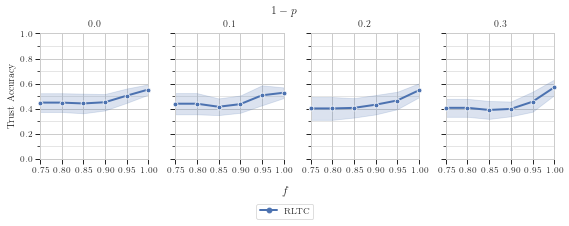

In [22]:
fig, axs = plot_metrics(df_main, metric_names, x_var="frac_reliable", control_var="noise", groupby_var="run_mode");

## Uncomment to save a copy as latex pgf format
fig.set_size_inches(w=8, h=3)
fig.set_tight_layout(True)
fig.savefig("trust_accuracy_debug.pgf", format="pgf", backend="pgf", bbox_inches='tight')